In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle

%matplotlib inline

font = 'Arial'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font
plt.rcParams['mathtext.bf'] = font
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

linewidth = 2.5

In [2]:
def extract_score(file_name, seed_list, test_flag, ver2_flag=1):
    total_score, total_len = None, 0
    total_sample = None
    for seed in seed_list:
        if test_flag == 0:
            df = pd.read_csv(file_name + str(seed) + '/train.csv')
        else:
            df = pd.read_csv(file_name + str(seed) + '/eval.csv')
        if total_score is None:
            if ver2_flag == 1:
                total_score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                total_score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                total_score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 4:
                total_score = df['episode_reward'].values
            elif ver2_flag == 5:
                total_score = df['true_episode_success'].values * 100
            else:
                total_score = df['success_rate'].values
            total_len = len(total_score)
            total_score = total_score.reshape(1, -1)
            total_sample = df['step'].values
            total_sample = total_sample.reshape(1, -1)
        else:
            if ver2_flag == 1:
                score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 4:
                score = df['episode_reward'].values
            elif ver2_flag == 5:
                score = df['true_episode_success'].values * 100
            else:
                score = df['success_rate'].values
            temp_len = len(score)
            score = score.reshape(1, -1)
            sample = df['step'].values
            sample = sample.reshape(1, -1)
            
            if temp_len < total_len:
                total_len = temp_len
                total_sample = sample
                
            total_score = np.concatenate(
                (total_score[:, :total_len], 
                 score[0][:total_len].reshape(1, -1)), 
                axis=0)
            
    total_avg = np.average(total_score, axis=0)
    total_std = np.std(total_score, axis=0)
    return total_avg, total_std, total_sample, total_score

In [3]:
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [4]:
def draw_figures(x_val, avg_val, std_val, ax, color, label, dash=False):
    if dash:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25, linestyle=':')
        
    else:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25)
    
    ax.fill_between(x_val, 
                    avg_val - std_val, 
                    avg_val + std_val, 
                    facecolor=color[:4], 
                    edgecolor=(0, 0, 0, 0))
    return ax

In [5]:
red_color = (247/255, 112/255, 136/255, 0.15)
blue_color = (128/255, 150/255, 244/255, 0.15)
dark_blue_color = (0/255, 83/255, 214/255, 0.15)
green_color = (51/255, 176/255, 122/255, 0.15)
purple_color = (204/255, 122/255, 244/255, 0.15)
orange_color = (255/255, 161/255, 0/255, 0.15)
black_color = (0/255, 0/255, 0/255, 0.15)
berkeley_blue_color = (0/255,50/255,98/255, 0.15)
cali_gold_color = (253/255,181/255,21/255, 0.15)
real_blue_color = (0/255, 0/255, 244/255, 0.15)
real_green_color = (0/255, 255/255, 0/255, 0.15)
real_red_color = (255/255, 0/255, 0/255, 0.15)
new_green_color = (92/255, 148/255, 13/255, 0.15) 
new_purple_color = (134/255, 46/255, 156/255, 0.15) 
new_yellow_color = (255/255, 224/255, 102/255, 0.15) 
deeppink_color = (255/255, 20/255, 147/255, 0.15)

color_list =[red_color, blue_color, dark_blue_color,
             green_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color]
color_max = len(color_list)

# Setup

In [6]:
domain_name = 'metaworld' # 'metaworld'
task_name = 'button-press-v2'
env_name = domain_name + '_' + task_name

arch = 'H256_L3'
sac_lr = 0.0003

# Normal - PPO

In [7]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PPO/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

# best
lr_list = [0.0003]
nstep_list = [250]
nenv_list = [8]
batch_list = [128]

ppo_normal_avg, ppo_normal_std, ppo_normal_step = dict(), dict(), dict()
s_ppo_normal_avg, s_ppo_normal_std, s_ppo_normal_step = dict(), dict(), dict()

ppo_normal_name_list = []

for lr in lr_list:
    for nstep in nstep_list:
        for batch in batch_list:
            for nenv in nenv_list:
                key = 'ppo: ns' + str(nstep) + '_lr' + str(lr) 
                key += '_ne' + str(nenv) + '_b' + str(batch)
                ppo_normal_name_list.append(key)
                file_name = root_dir + 'normalized_' + env_name

                file_name += '/lr_' + str(lr) 
                file_name += '_batch_' + str(batch)
                file_name += '_nenvs_' + str(nenv)
                file_name += '_nsteps_'+ str(nstep)
                file_name += '_ent_0.0_hidden_256'
                file_name += '_sde_1_sdefreq_4_gae_0.92_clip_0.4_nepochs_20_seed_'
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
                ppo_normal_avg[key] = total_avg
                ppo_normal_std[key] = total_std
                ppo_normal_step[key] = total_sample
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
                s_ppo_normal_avg[key] = total_avg
                s_ppo_normal_std[key] = total_std
                s_ppo_normal_step[key] = total_sample

In [8]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PPO_Unsuper/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

# best
lr_list = [0.0003]
nstep_list = [250]
nenv_list = [8]
batch_list = [128]

ppo_un_normal_avg, ppo_un_normal_std, ppo_un_normal_step = dict(), dict(), dict()
s_ppo_un_normal_avg, s_ppo_un_normal_std, s_ppo_un_normal_step = dict(), dict(), dict()

ppo_un_normal_name_list = []

for lr in lr_list:
    for nstep in nstep_list:
        for batch in batch_list:
            for nenv in nenv_list:
                key = 'ppo un: ns' + str(nstep) + '_lr' + str(lr) 
                key += '_ne' + str(nenv) + '_b' + str(batch)
                ppo_un_normal_name_list.append(key)
                file_name = root_dir + 'normalized_' + env_name

                file_name += '/lr_' + str(lr) 
                file_name += '_batch_' + str(batch)
                file_name += '_nenvs_' + str(nenv)
                file_name += '_nsteps_'+ str(nstep)
                file_name += '_ent_0.0_hidden_256'
                file_name += '_sde_1_sdefreq_4_gae_0.92_clip_0.4_nepochs_20_unsuper_32000_update_50_seed_'
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
                ppo_un_normal_avg[key] = total_avg
                ppo_un_normal_std[key] = total_std
                ppo_un_normal_step[key] = total_sample
                total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
                s_ppo_un_normal_avg[key] = total_avg
                s_ppo_un_normal_std[key] = total_std
                s_ppo_un_normal_step[key] = total_sample

In [9]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PrefPPO/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

un_pre_ppo_avg, un_pre_ppo_std, un_pre_ppo_step = dict(), dict(), dict()
s_un_pre_ppo_avg, s_un_pre_ppo_std, s_un_pre_ppo_step = dict(), dict(), dict()
un_pre_ppo_name_list = []

un_pre_ppo_tot, s_un_pre_ppo_tot = dict(), dict()


lr= 0.0003
feed_type = 1

fedd_teacher_option_list = [
#     (32000, 25, 10000, 250, 16, 'o'),
#     (32000, 50, 10000, 250, 16, 'o'),
#     (32000, 25, 10000, 250, 64, 'o'),
#     (32000, 50, 10000, 250, 64, 'o'),
#     (16000, 25, 10000, 100, 16, 'o'),
#     (16000, 50, 10000, 100, 16, 'o'),
#     (16000, 25, 10000, 100, 64, 'o'),
    (16000, 50, 10000, 100, 64, 'o'), # best
#     (8000, 25, 10000, 50, 16, 'o'),
#     (8000, 50, 10000, 50, 16, 'o'),
#     (8000, 25, 10000, 50, 64, 'o'),
#     (8000, 50, 10000, 50, 64, 'o'),

#     (32000, 25, 20000, 500, 16, 'o'),
#     (32000, 50, 20000, 500, 16, 'o'),
    (32000, 25, 20000, 500, 64, 'o'), # best
#     (32000, 50, 20000, 500, 64, 'o'),
#     (16000, 25, 20000, 200, 16, 'o'),
#     (16000, 50, 20000, 200, 16, 'o'),
#     (16000, 25, 20000, 200, 64, 'o'),
#     (16000, 50, 20000, 200, 64, 'o'),
#     (8000, 25, 20000, 100, 16, 'o'),
#     (8000, 50, 20000, 100, 16, 'o'),
#     (8000, 25, 20000, 100, 64, 'o'),
#     (8000, 50, 20000, 100, 64, 'o'),
    
#     (32000, 25, 10000, 250, 16, 'e'),
#     (32000, 50, 10000, 250, 16, 'e'),
    (32000, 25, 10000, 250, 64, 'e'), # best
#     (32000, 50, 10000, 250, 64, 'e'),
#     (16000, 25, 10000, 100, 16, 'e'),
#     (16000, 50, 10000, 100, 16, 'e'),
#     (16000, 25, 10000, 100, 64, 'e'),
#     (16000, 50, 10000, 100, 64, 'e'),
#     (8000, 25, 10000, 50, 16, 'e'),
#     (8000, 50, 10000, 50, 16, 'e'),
#     (8000, 25, 10000, 50, 64, 'e'),
#     (8000, 50, 10000, 50, 64, 'e'),

#     (32000, 25, 20000, 500, 16, 'e'),
#     (32000, 50, 20000, 500, 16, 'e'),
    (32000, 25, 20000, 500, 64, 'e'),
#     (32000, 50, 20000, 500, 64, 'e'),
#     (16000, 25, 20000, 200, 16, 'e'),
#     (16000, 50, 20000, 200, 16, 'e'),
#     (16000, 25, 20000, 200, 64, 'e'),
#     (16000, 50, 20000, 200, 64, 'e'),
#     (8000, 25, 20000, 100, 16, 'e'),
#     (8000, 50, 20000, 100, 16, 'e'),
#     (8000, 25, 20000, 100, 64, 'e'),
#     (8000, 50, 20000, 100, 64, 'e'),
    
#     (32000, 25, 10000, 250, 16, 's'),
#     (32000, 50, 10000, 250, 16, 's'),
#     (32000, 25, 10000, 250, 64, 's'),
#     (32000, 50, 10000, 250, 64, 's'),
#     (16000, 25, 10000, 100, 16, 's'),
#     (16000, 50, 10000, 100, 16, 's'),
#     (16000, 25, 10000, 100, 64, 's'),
#     (16000, 50, 10000, 100, 64, 's'),
#     (8000, 25, 10000, 50, 16, 's'),
#     (8000, 50, 10000, 50, 16, 's'),
#     (8000, 25, 10000, 50, 64, 's'),
    (8000, 50, 10000, 50, 64, 's'),

#     (32000, 25, 20000, 500, 16, 's'),
#     (32000, 50, 20000, 500, 16, 's'),
#     (32000, 25, 20000, 500, 64, 's'),
#     (32000, 50, 20000, 500, 64, 's'),
#     (16000, 25, 20000, 200, 16, 's'),
#     (16000, 50, 20000, 200, 16, 's'),
#     (16000, 25, 20000, 200, 64, 's'),
#     (16000, 50, 20000, 200, 64, 's'),
#     (8000, 25, 20000, 100, 16, 's'),
#     (8000, 50, 20000, 100, 16, 's'),
    (8000, 25, 20000, 100, 64, 's'),
#     (8000, 50, 20000, 100, 64, 's'),
    
#     (32000, 25, 10000, 250, 16, 'n'),
#     (32000, 50, 10000, 250, 16, 'n'),
#     (32000, 25, 10000, 250, 64, 'n'),
#     (32000, 50, 10000, 250, 64, 'n'),
#     (16000, 25, 10000, 100, 16, 'n'),
#     (16000, 50, 10000, 100, 16, 'n'),
#     (16000, 25, 10000, 100, 64, 'n'),
#     (16000, 50, 10000, 100, 64, 'n'),
#     (8000, 25, 10000, 50, 16, 'n'),
#     (8000, 50, 10000, 50, 16, 'n'),
#     (8000, 25, 10000, 50, 64, 'n'),
    (8000, 50, 10000, 50, 64, 'n'),

#     (32000, 25, 20000, 500, 16, 'n'),
#     (32000, 50, 20000, 500, 16, 'n'),
#     (32000, 25, 20000, 500, 64, 'n'),
#     (32000, 50, 20000, 500, 64, 'n'),
#     (16000, 25, 20000, 200, 16, 'n'),
#     (16000, 50, 20000, 200, 16, 'n'),
#     (16000, 25, 20000, 200, 64, 'n'),
    (16000, 50, 20000, 200, 64, 'n'),
#     (8000, 25, 20000, 100, 16, 'n'),
#     (8000, 50, 20000, 100, 16, 'n'),
#     (8000, 25, 20000, 100, 64, 'n'),
#     (8000, 50, 20000, 100, 64, 'n'),
    
#     (32000, 25, 10000, 250, 16, 'mi'),
#     (32000, 50, 10000, 250, 16, 'mi'),
    (32000, 25, 10000, 250, 64, 'mi'),
#     (32000, 50, 10000, 250, 64, 'mi'),
#     (16000, 25, 10000, 100, 16, 'mi'),
#     (16000, 50, 10000, 100, 16, 'mi'),
#     (16000, 25, 10000, 100, 64, 'mi'),
#     (16000, 50, 10000, 100, 64, 'mi'),
#     (8000, 25, 10000, 50, 16, 'mi'),
#     (8000, 50, 10000, 50, 16, 'mi'),
#     (8000, 25, 10000, 50, 64, 'mi'),
#     (8000, 50, 10000, 50, 64, 'mi'),

#     (32000, 25, 20000, 500, 16, 'mi'),
#     (32000, 50, 20000, 500, 16, 'mi'),
    (32000, 25, 20000, 500, 64, 'mi'),
#     (32000, 50, 20000, 500, 64, 'mi'),
#     (16000, 25, 20000, 200, 16, 'mi'),
#     (16000, 50, 20000, 200, 16, 'mi'),
#     (16000, 25, 20000, 200, 64, 'mi'),
#     (16000, 50, 20000, 200, 64, 'mi'),
#     (8000, 25, 20000, 100, 16, 'mi'),
#     (8000, 50, 20000, 100, 16, 'mi'),
#     (8000, 25, 20000, 100, 64, 'mi'),
#     (8000, 50, 20000, 100, 64, 'mi'),
    
#     (32000, 25, 10000, 250, 16, 'my'),
#     (32000, 50, 10000, 250, 16, 'my'),
#     (32000, 25, 10000, 250, 64, 'my'),
    (32000, 50, 10000, 250, 64, 'my'),
#     (16000, 25, 10000, 100, 16, 'my'),
#     (16000, 50, 10000, 100, 16, 'my'),
#     (16000, 25, 10000, 100, 64, 'my'),
#     (16000, 50, 10000, 100, 64, 'my'),
#     (8000, 25, 10000, 50, 16, 'my'),
#     (8000, 50, 10000, 50, 16, 'my'),
#     (8000, 25, 10000, 50, 64, 'my'),
#     (8000, 50, 10000, 50, 64, 'my'),

#     (32000, 25, 20000, 500, 16, 'my'),
#     (32000, 50, 20000, 500, 16, 'my'),
#     (32000, 25, 20000, 500, 64, 'my'),
#     (32000, 50, 20000, 500, 64, 'my'),
#     (16000, 25, 20000, 200, 16, 'my'),
#     (16000, 50, 20000, 200, 16, 'my'),
    (16000, 25, 20000, 200, 64, 'my'),
#     (16000, 50, 20000, 200, 64, 'my'),
#     (8000, 25, 20000, 100, 16, 'my'),
#     (8000, 50, 20000, 100, 16, 'my'),
#     (8000, 25, 20000, 100, 64, 'my'),
#     (8000, 50, 20000, 100, 64, 'my'),

]

for interact, seg_size, max_feed, rbatch, nenvs, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_1.0_1.0_0.0_0.0_0.0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_-1.0_0.9_0.0_0.0_0.0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_-1.0_1.0_0.1_0.0_0.0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.1_0.0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.0_0.0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_-1.0_1.0_0.0_0.0_0.1'

    key = 'PrePPO [' + str(feed_type) + '] (max='+ str(max_feed) + ', seg=' + str(seg_size)
    key += ', int=' + str(interact) + ', rb=' + str(rbatch) + ', nenv=' + str(nenvs)
    key += ', te=' + str(teacher_index) + ')'
    un_pre_ppo_name_list.append(key)
    
#     print('--')
#     print(interact)
#     print(seg_size)
#     print(teacher_index)
#     print(nenvs)
#     print(max_feed)
#     print(rbatch)
    file_name = root_dir + 'normalized_' + env_name
    file_name += teacher_dir
    file_name += '/lr_' + str(lr) + '_reward_lr0.0003_seg' + str(seg_size) + '_acttanh'
    file_name += '_inter' + str(interact) + '_type' + str(feed_type)
    file_name += '_large10_rebatch' + str(rbatch)
    file_name += '_reupdate50_batch_128'
    file_name += '_nenvs_' + str(nenvs)
    file_name += '_nsteps_250_ent_0.0_hidden_256_sde_1_sdefreq_4'
    file_name += '_gae_0.92_clip_0.4_nepochs_20_maxfeed_'+str(max_feed)
    file_name += '_unsuper_32000_update_50'
    file_name += '_seed_'
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    un_pre_ppo_avg[key] = total_avg
    un_pre_ppo_std[key] = total_std
    un_pre_ppo_step[key] = total_sample
    un_pre_ppo_tot[key] = total_score
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=5)
    s_un_pre_ppo_avg[key] = total_avg
    s_un_pre_ppo_std[key] = total_std
    s_un_pre_ppo_step[key] = total_sample
    s_un_pre_ppo_tot[key] = total_score

# PPO PLOT

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


mean: 3128.929456895
std: 148.6836844357127
mean: 99.0
std: 2.5
mean: 1971.8396921275003
std: 1023.6136649230542
mean: 73.0
std: 36.585663685974666
mean: 806.5089714696876
std: 325.8260527443054
mean: 60.0
std: 19.21145194990271
mean: 911.7838173721875
std: 429.2780867219259
mean: 65.21875
std: 12.578892861640481


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


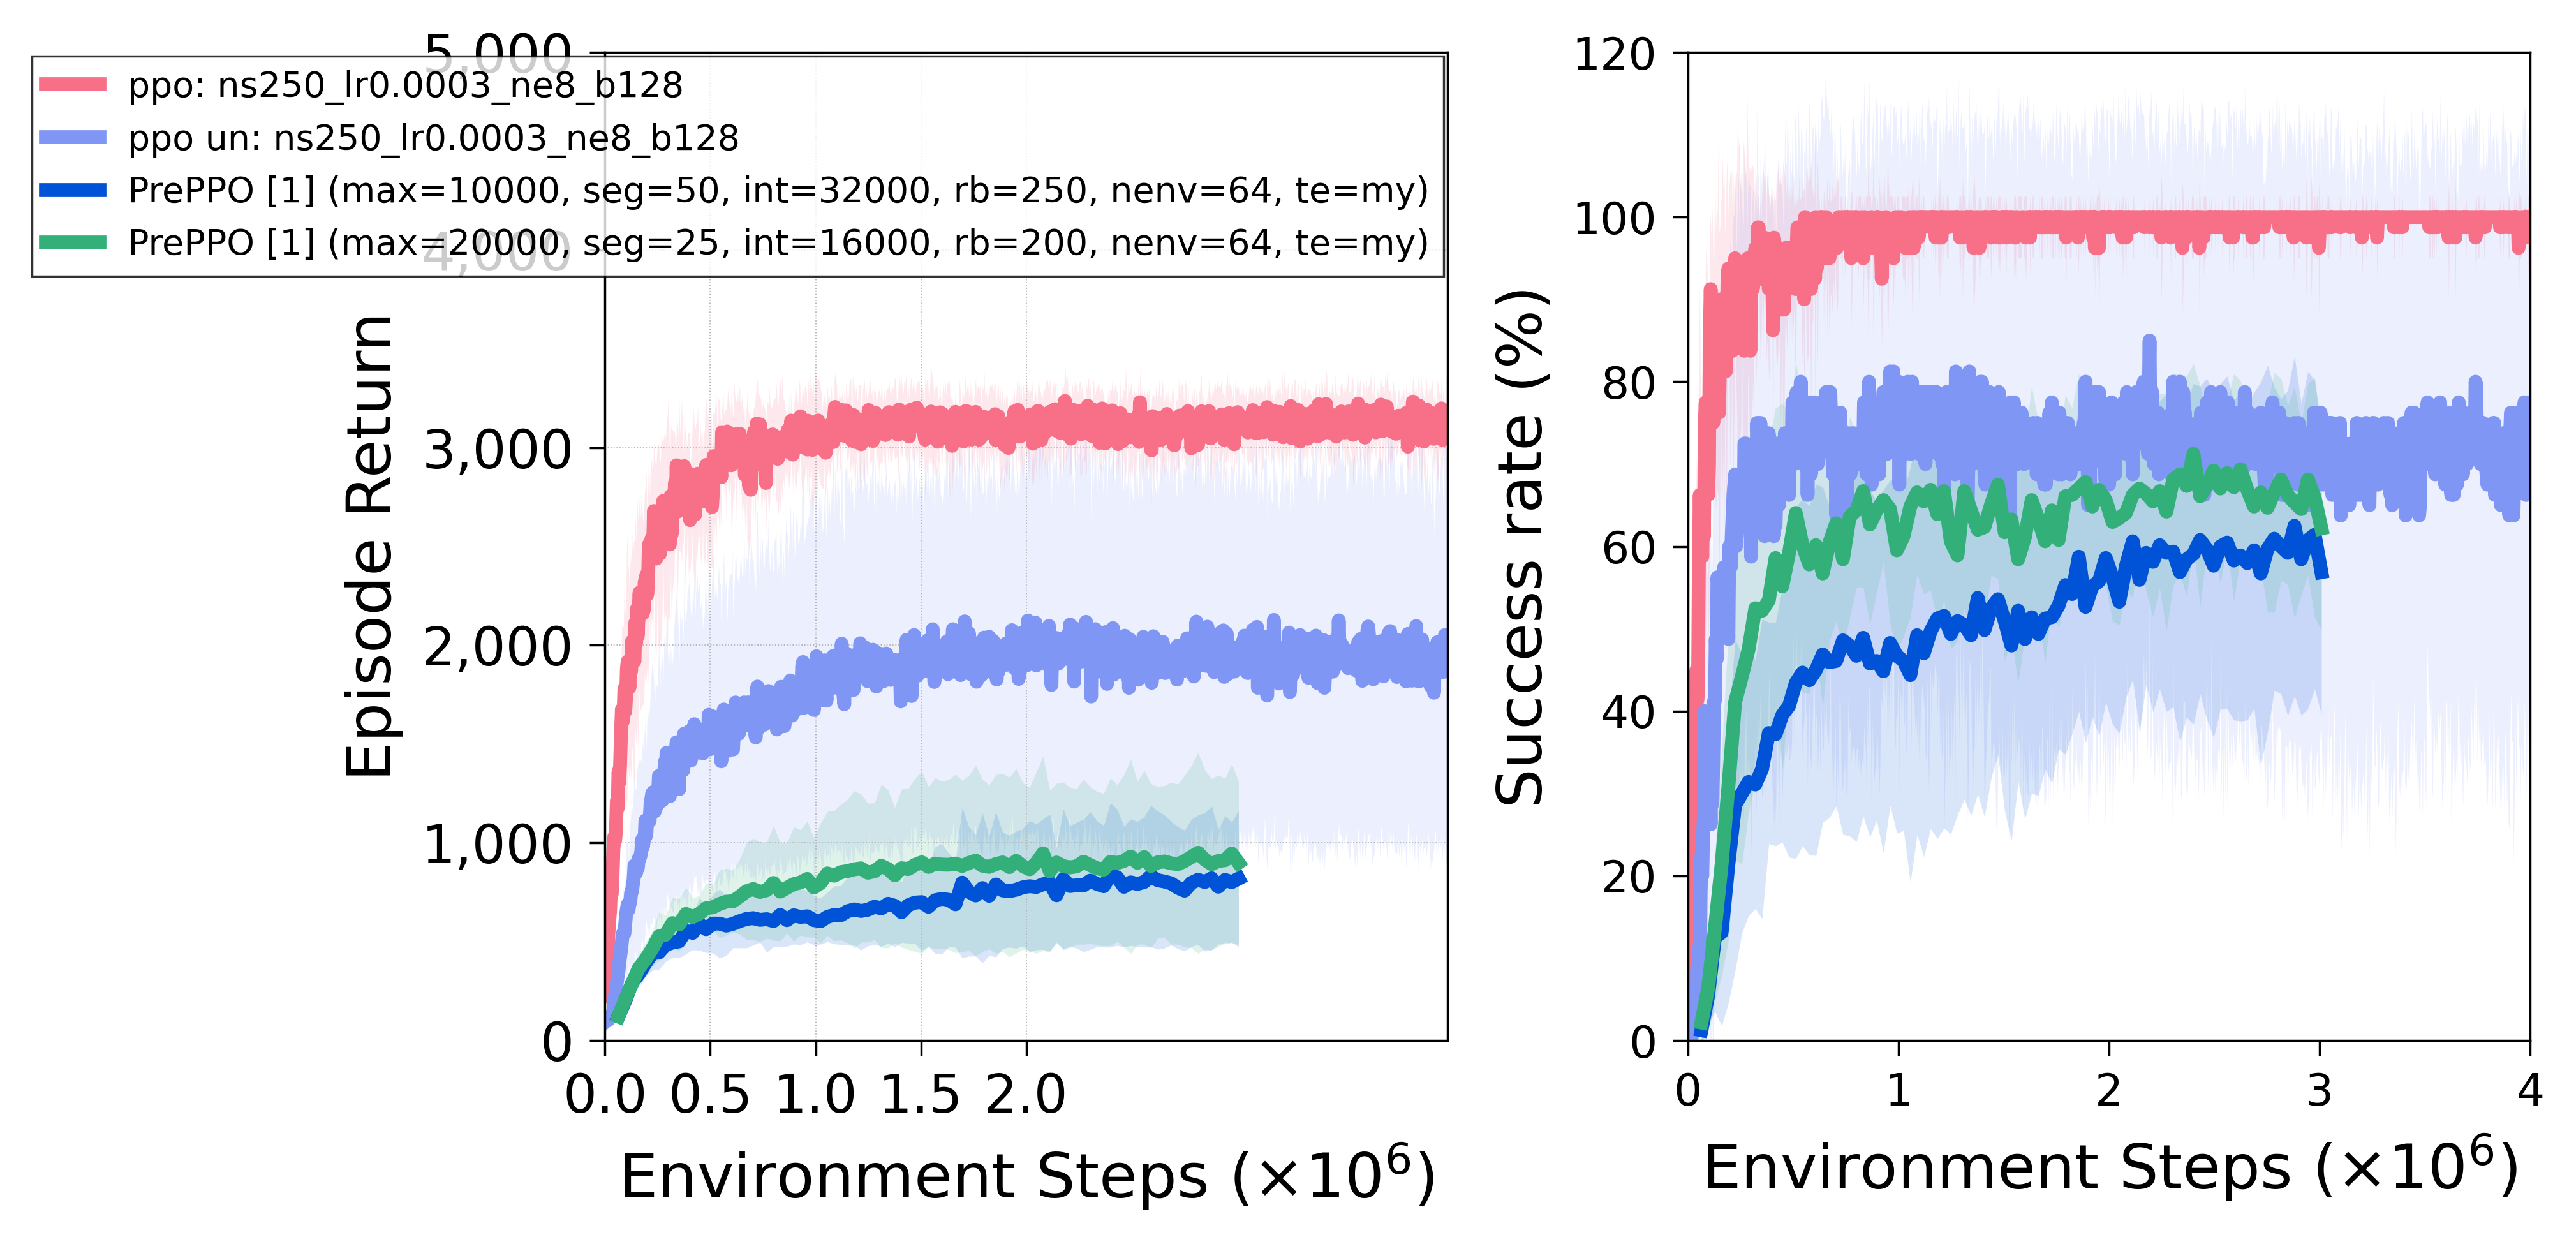

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=500)

base = 1000000

ppo_converge = -5
count = 0
teacher_flag = 'te=my'

for name in ppo_normal_name_list:            
    label = name
    score = ppo_normal_avg[name]
    std = ppo_normal_std[name]
    steps = ppo_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    label = name
    score = s_ppo_normal_avg[name]
    std = s_ppo_normal_std[name]
    steps = s_ppo_normal_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    count += 1

for name in ppo_un_normal_name_list:            
    label = name
    score = ppo_un_normal_avg[name]
    std = ppo_un_normal_std[name]
    steps = ppo_un_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    label = name
    score = s_ppo_un_normal_avg[name]
    std = s_ppo_un_normal_std[name]
    steps = s_ppo_un_normal_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    print('mean: ' + str(np.mean(score[ppo_converge:])))
    print('std: ' + str(np.mean(std[ppo_converge:])))
    
    count += 1

for name in un_pre_ppo_name_list :            
    label = name
    score = un_pre_ppo_avg[name]
    std = un_pre_ppo_std[name]
    steps = un_pre_ppo_step[name].reshape(-1)
    if teacher_flag in label:
        c_count = count % len(color_list)
        ax[0] = draw_figures(steps/base, score, std, ax[0], 
                          color_list[c_count], label)
        print('mean: ' + str(np.mean(score[ppo_converge:])))
        print('std: ' + str(np.mean(std[ppo_converge:])))

        label = name
        score = s_un_pre_ppo_avg[name]
        std = s_un_pre_ppo_std[name]
        steps = s_un_pre_ppo_step[name].reshape(-1)
        ax[1] = draw_figures(steps/base, score, std, ax[1], 
                          color_list[c_count], label)
        print('mean: ' + str(np.mean(score[ppo_converge:])))
        print('std: ' + str(np.mean(std[ppo_converge:])))

        count += 1
    
    
ax[0].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[0].set_ylabel('Episode Return', fontsize=14)
ax[1].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[1].set_ylabel('Success rate (%)', fontsize=14)


ax[0].grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[0].set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax[0].set_xticks([0, 0.5, 1, 1.5, 2])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax[0].get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax[0].xaxis.major.formatter._useMathText = True

ax[0].set_xlim(0, 4)
ax[0].set_ylim(0, 5000)
ax[1].set_xlim(0, 4)
ax[1].set_ylim(0, 120)

leg = ax[0].legend(fancybox=False, fontsize=8, 
                   edgecolor='black', borderaxespad=0.1, handlelength=1.5)
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# Normal - SAC

In [11]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr_list = [0.0003]

sac_normal_avg, sac_normal_std, sac_normal_step = dict(), dict(), dict()
sac_normal_s_avg, sac_normal_s_std, sac_normal_s_step = dict(), dict(), dict()

sac_normal_name_list = []

for lr in lr_list:
    key = 'sac: normal ' + str(lr)
    sac_normal_name_list.append(key)
    file_name = root_dir + env_name + '/H256_L3_B512_tau0.005/'
    file_name += '/sac_sac_lr' + str(lr) + '_temp0.1_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    sac_normal_avg[key] = total_avg
    sac_normal_std[key] = total_std
    sac_normal_step[key] = total_sample
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_normal_s_avg[key] = total_avg
    sac_normal_s_std[key] = total_std
    sac_normal_s_step[key] = total_sample

In [12]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC_UNSUPER/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.0003

sac_un_normal_avg, sac_un_normal_std, sac_un_normal_step = dict(), dict(), dict()
sac_un_normal_s_avg, sac_un_normal_s_std, sac_un_normal_s_step = dict(), dict(), dict()

sac_un_normal_name_list = []

unsup_list= [
#     (5, 9000), 
#     (5, 99000), 
    (16, 99000)
]

for topK, unsup in unsup_list:
    key = 'sac: unsup K' + str(topK) + ', un' + str(unsup)
    sac_un_normal_name_list.append(key)
    file_name = root_dir + env_name + '/H256_L3_B512_tau0.005/'
    file_name += '/sac_unsup' + str(unsup)
    file_name += '_topk' + str(topK)
    file_name += '_sac_lr' + str(lr) + '_temp0.1_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=4)
    sac_un_normal_avg[key] = total_avg
    sac_un_normal_std[key] = total_std
    sac_un_normal_step[key] = total_sample
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_un_normal_s_avg[key] = total_avg
    sac_un_normal_s_std[key] = total_std
    sac_un_normal_s_step[key] = total_sample

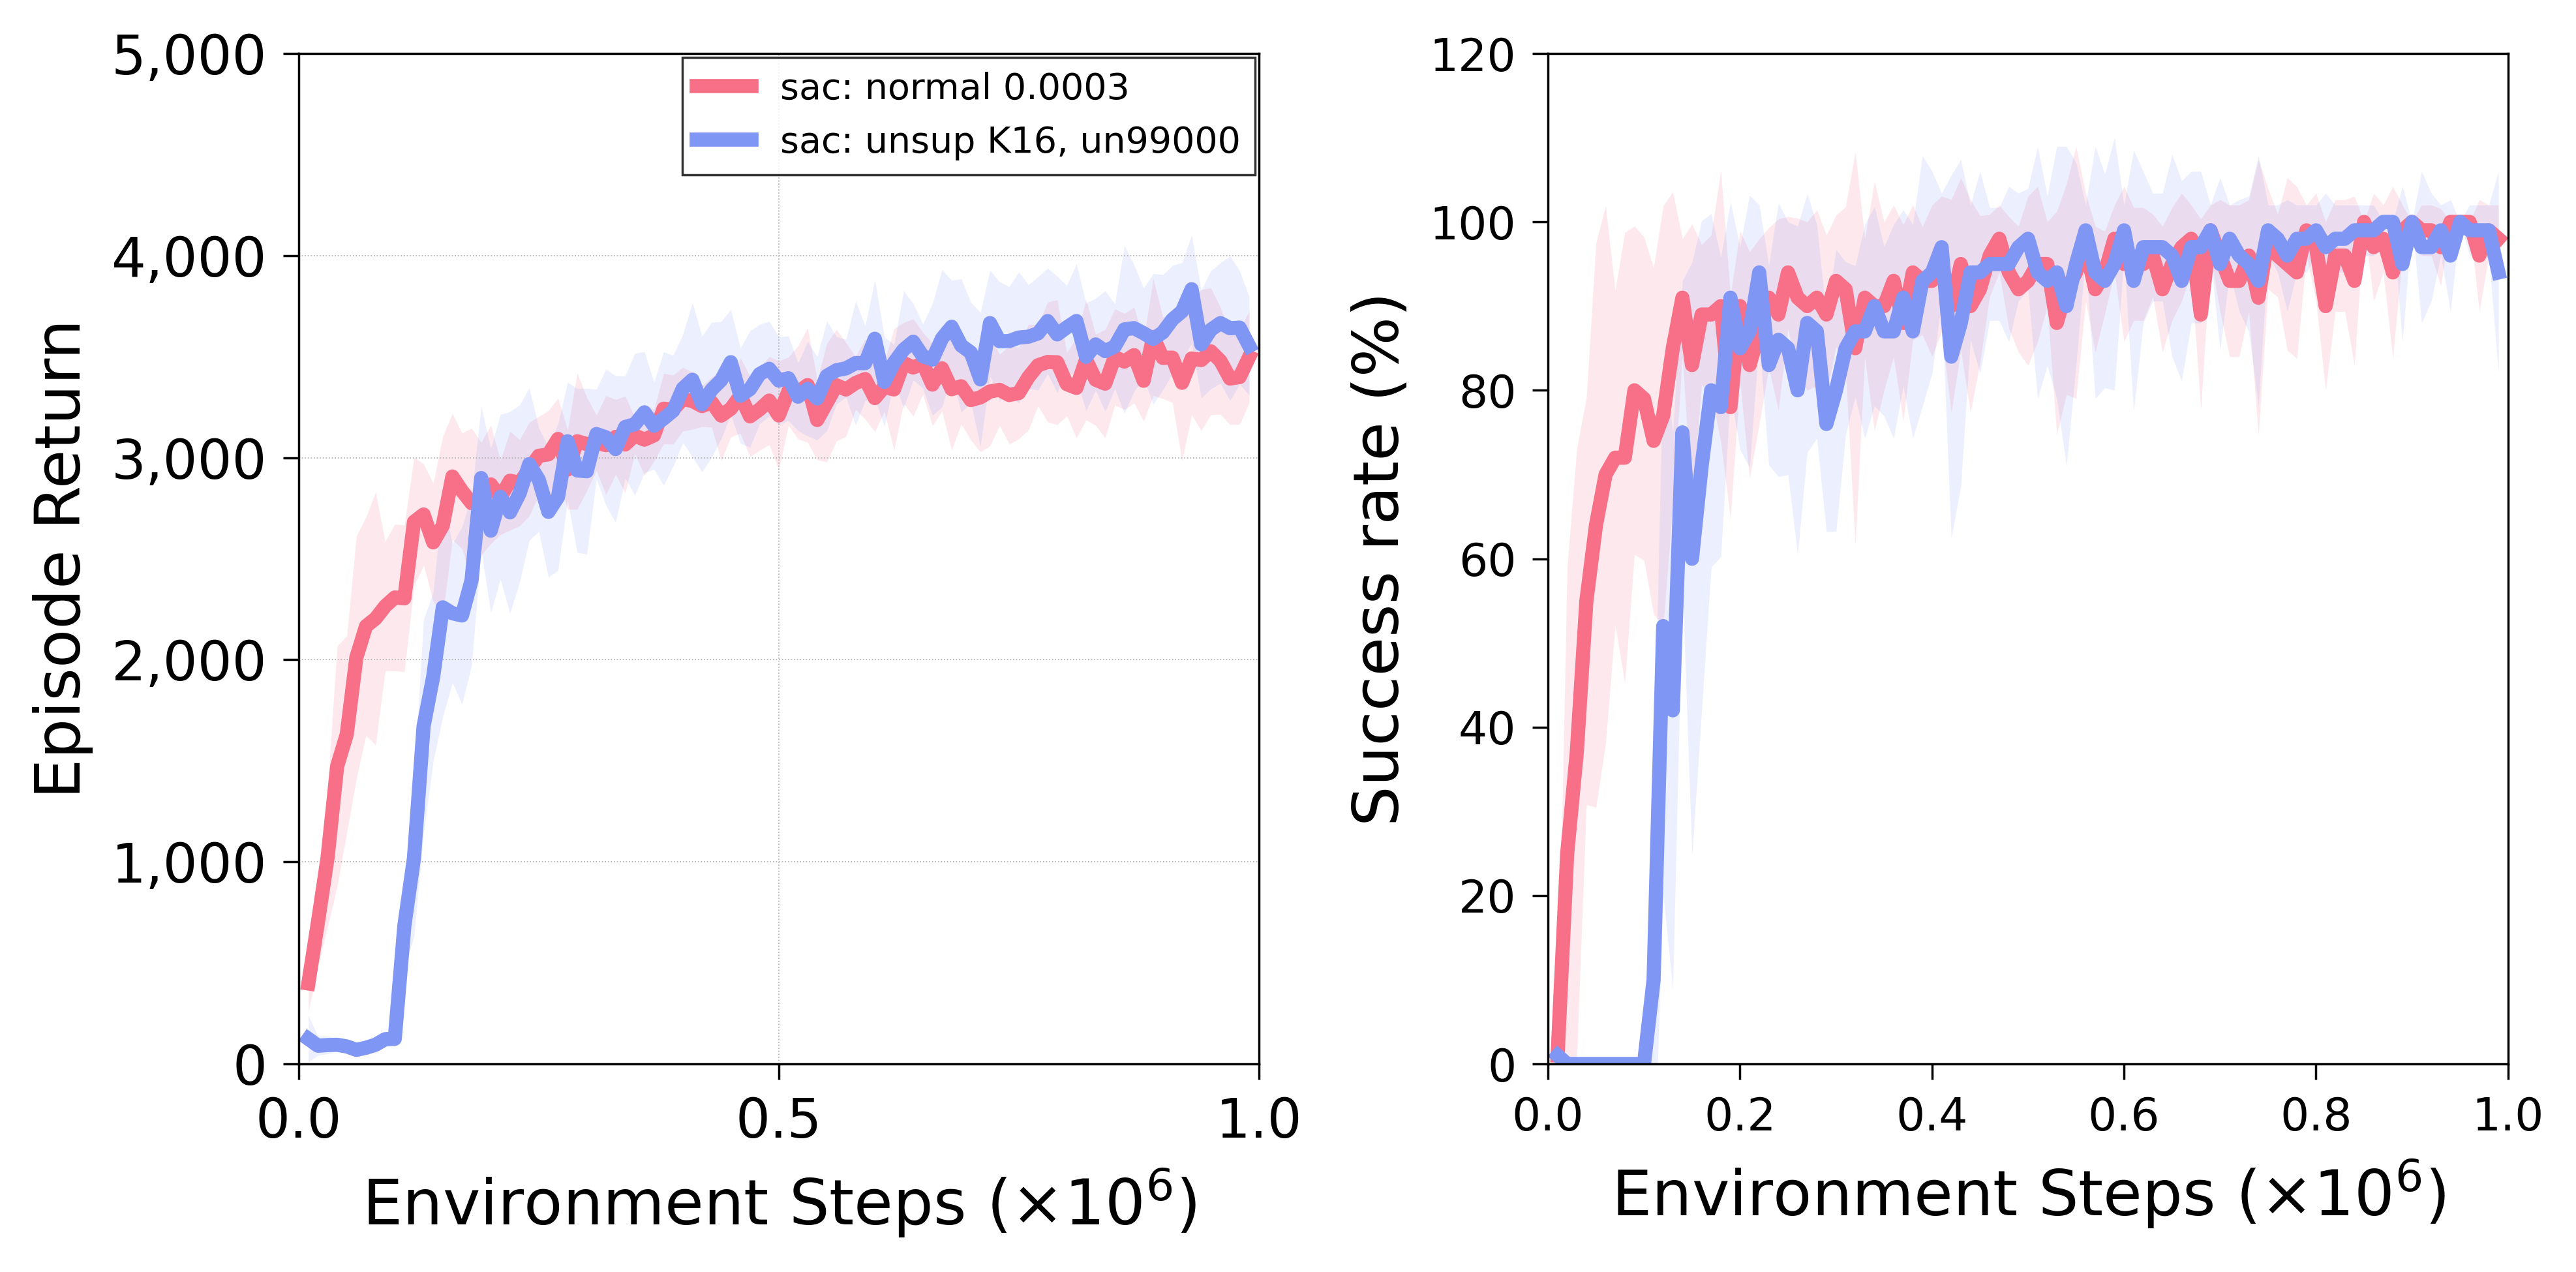

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=500)

base = 1000000

ppo_converge = -5
count = 0
teacher_flag = 'te=s'

for name in sac_normal_name_list:            
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    steps = sac_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)
    
    label = name
    score = sac_normal_s_avg[name]
    std = sac_normal_s_std[name]
    steps = sac_normal_s_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    count += 1
    
for name in sac_un_normal_name_list:            
    label = name
    score = sac_un_normal_avg[name]
    std = sac_un_normal_std[name]
    steps = sac_un_normal_step[name].reshape(-1)
    ax[0] = draw_figures(steps/base, score, std, ax[0], 
                      color_list[count], label)

    label = name
    score = sac_un_normal_s_avg[name]
    std = sac_un_normal_s_std[name]
    steps = sac_un_normal_s_step[name].reshape(-1)
    ax[1] = draw_figures(steps/base, score, std, ax[1], 
                      color_list[count], label)
    count += 1

ax[0].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[0].set_ylabel('Episode Return', fontsize=14)
ax[1].set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax[1].set_ylabel('Success rate (%)', fontsize=14)


ax[0].grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[0].set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax[0].set_xticks([0, 0.5, 1])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax[0].get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax[0].xaxis.major.formatter._useMathText = True

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 5000)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 120)

leg = ax[0].legend(fancybox=False, fontsize=8, 
                   edgecolor='black', borderaxespad=0.1, handlelength=1.5)
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# PEBBLE

In [14]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PEBBLE/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.0003

ori_interact = 5000
ori_num_feed = 100
ori_num_feed_2 = 50

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False

fedd_teacher_option_list = [
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    
    (ori_interact, 1, 20000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
]

new_pebble_avg, new_pebble_std, new_pebble_step = dict(), dict(), dict()
new_pebble_s_avg, new_pebble_s_std, new_pebble_s_step = dict(), dict(), dict()
new_noise_avg, new_noise_std, new_noise_step = dict(), dict(), dict()

new_pebble_total = dict()
new_pebble_s_total = dict()

new_pebble_name_list = []
teacher_dir = ''
for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_b1_g1_m0_s0_e0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_b-1_g0.9_m0_s0_e0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_b-1_g1_m0.1_s0_e0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_b-1_g1_m0_s0.1_e0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0.1'

    key = 'PEBBLE [' + str(feed_type) + '] (num_feed='+ str(num_feed) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,seg=' + str(segment) + ')'
    new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate10_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
        
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1)
    new_pebble_avg[key] = total_avg
    new_pebble_std[key] = total_std
    new_pebble_step[key] = total_sample
    new_pebble_total[key] = total_score
    
    total_avg, total_std, total_sample, total_score = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    new_pebble_s_avg[key] = total_avg
    new_pebble_s_std[key] = total_std
    new_pebble_s_step[key] = total_sample
    new_pebble_s_total[key] = total_score

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


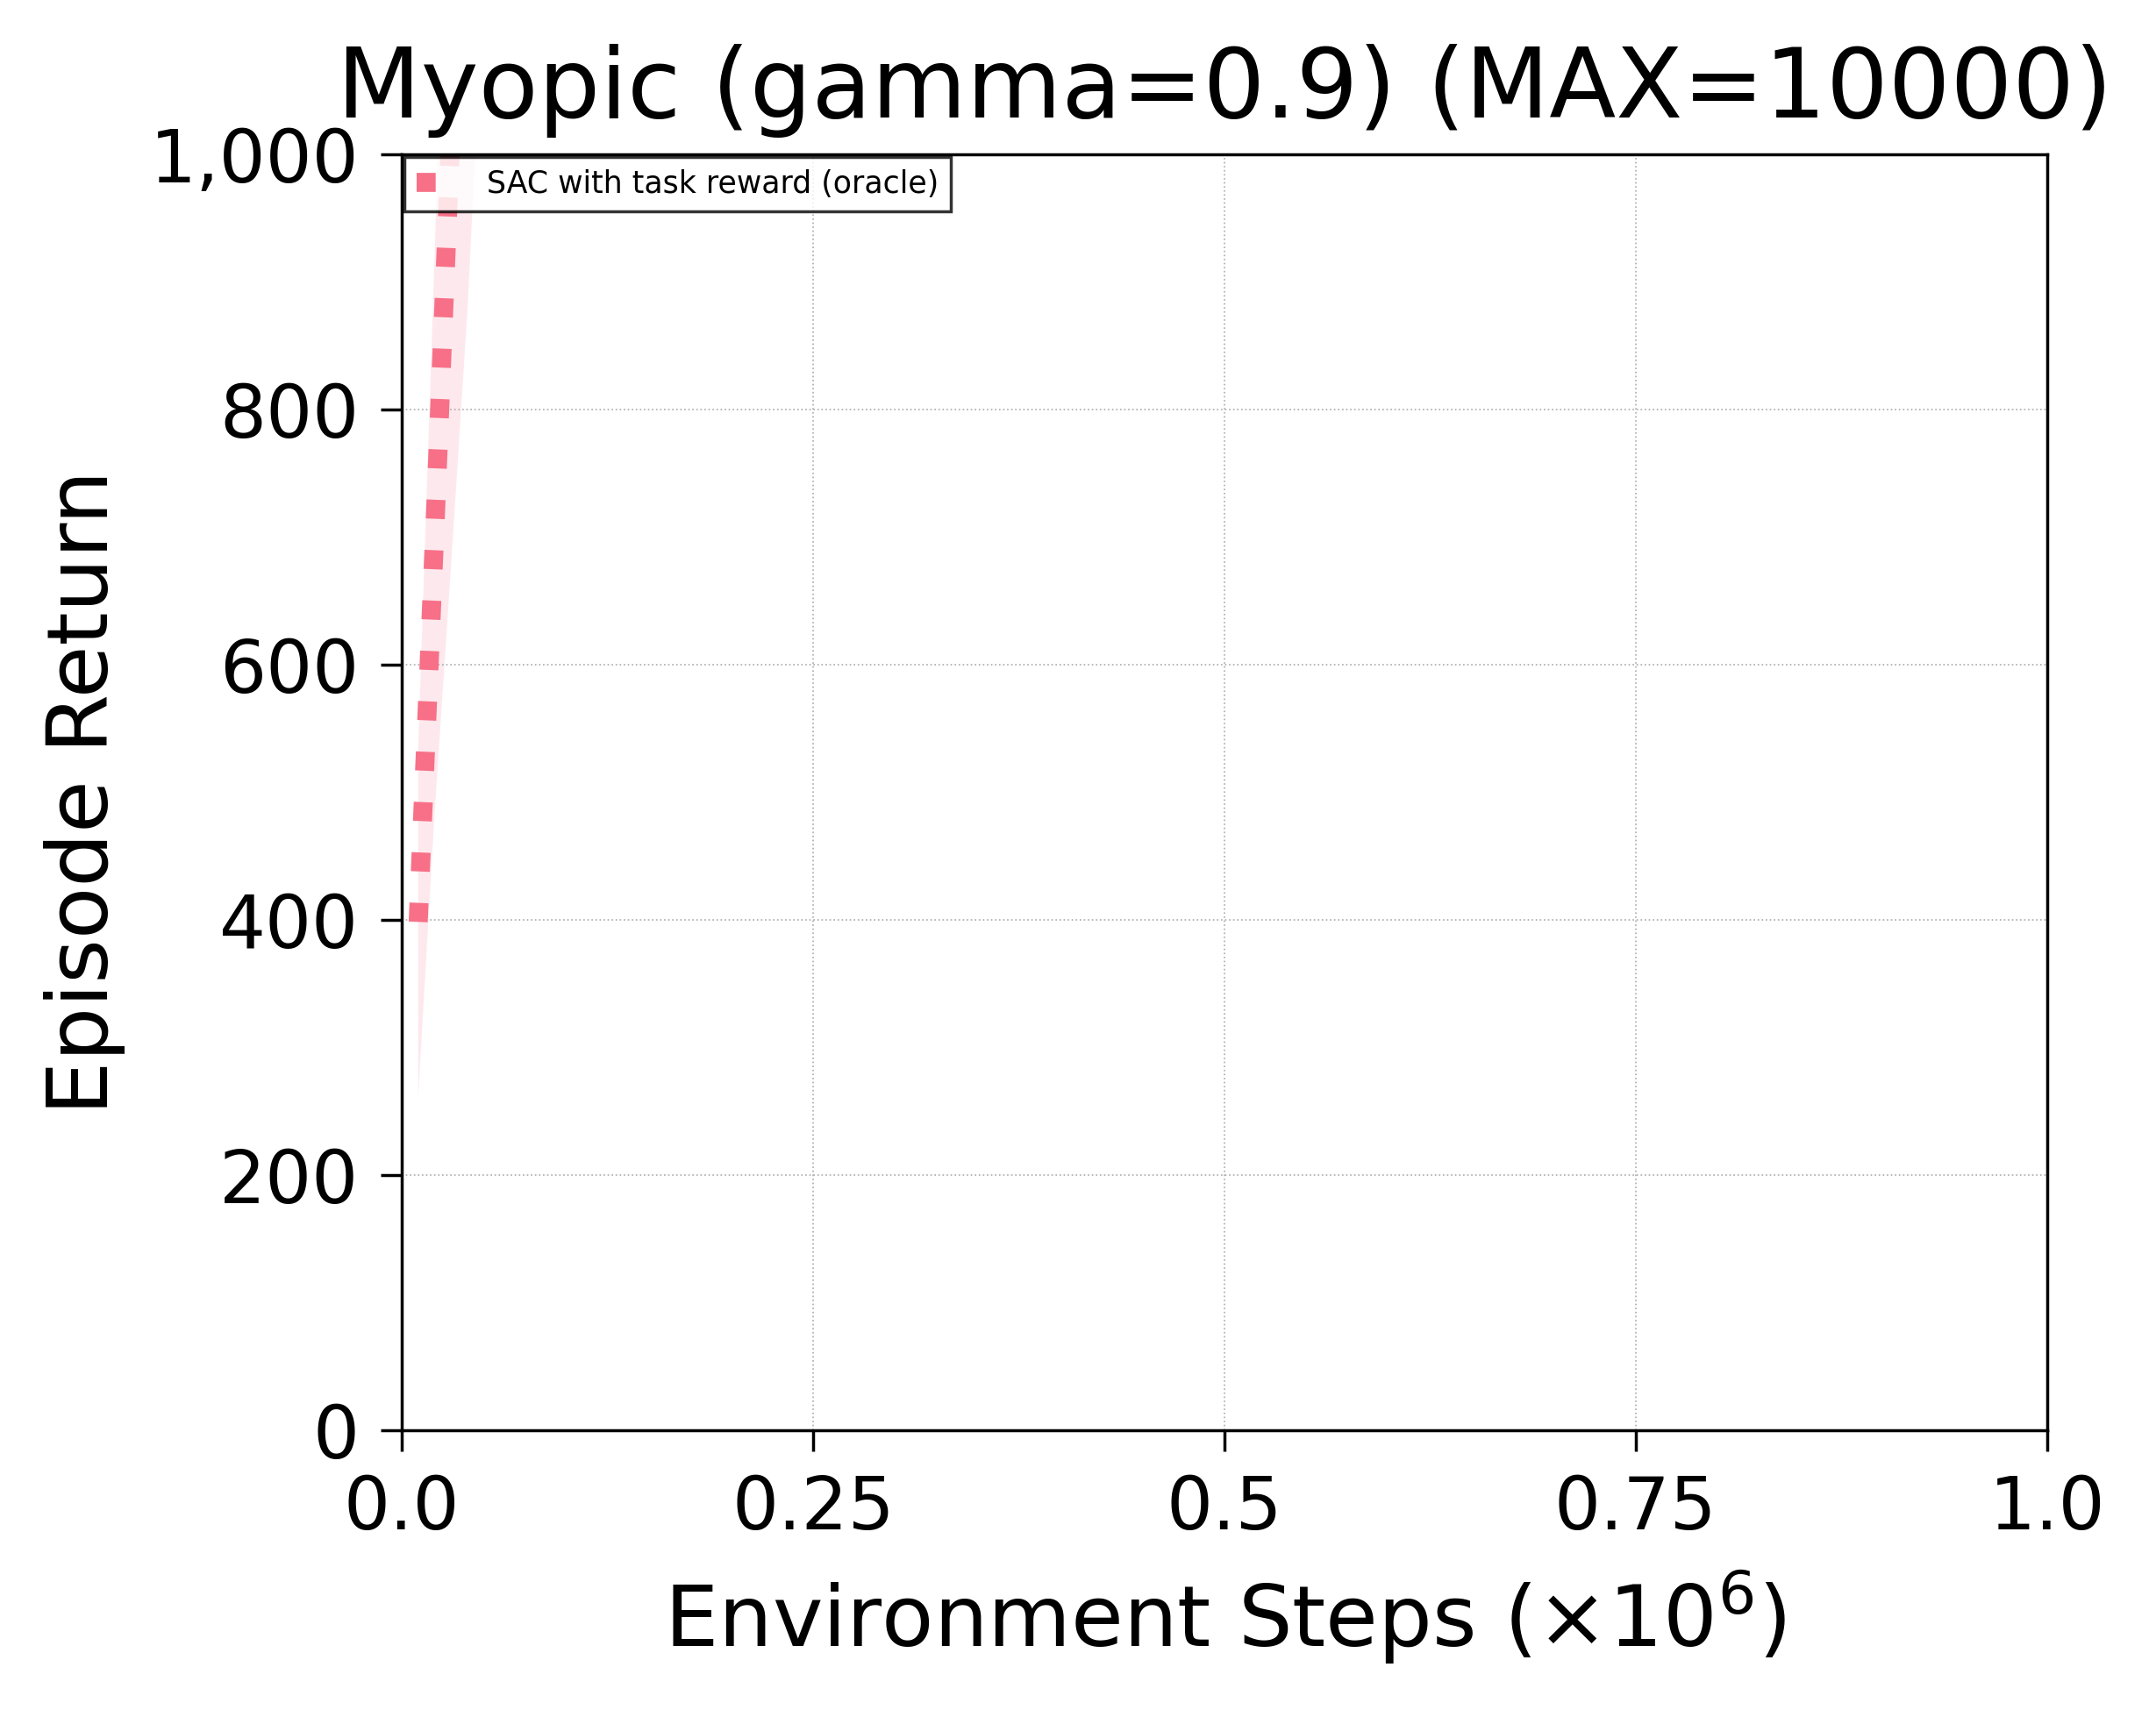

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000

ours_flag_list = ['[0]', '[1]', '[2]', 
                  '[3]', '[6]', '[7]', 
                  '[12]', '[13]', '[14]', 
                  '[15]', '[16]', '[17]']
ours_name_list = ['Uniform', 'Disagree', 'Entropy', 
                  'Uniform + Exploit', 'Entropy + Exploit', 'Disagree + Exploit',
                  'Uniform + Kcenter', 'Entropy + Kcenter', 'Disagree + Kcenter', 
                  'Uniform + Kcenter + exploit', 'Entropy + Kcenter + exploit', 
                  'Disagree + Kcenter + exploit']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
print_teacher = 'te=9'
schedule_type = 'sch=0'

for name in sac_normal_name_list:
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    steps = sac_normal_step[name].reshape(-1)
    ax = draw_figures(steps/base, score, std, ax, 
                      sac_color, sac_name, 1)  
    
for name in new_pebble_name_list:
    label = name
    score = new_pebble_avg[name]
    std = new_pebble_std[name]
    steps = new_pebble_step[name].reshape(-1)
    
    for index_ in range(len(ours_flag_list)):
        ours_flag = ours_flag_list[index_]
        ours_name = ours_name_list[index_]
        ours_color = color_list[index_ + 1]
        if ours_flag in name and schedule_type in name and print_teacher in name:
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, ours_name)
            print(ours_name + "  %.1f $\pm$ %.1f"%(np.mean(score[-2:]), np.mean(std[-2:])))
            
ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=14)
ax.set_ylabel('Episode Return', fontsize=14)

if print_teacher == 'te=0':
    teacher_name = 'Ideal teacher'
elif print_teacher == 'te=5':
    teacher_name = 'Noisy teacher'
elif print_teacher == 'te=7':
    teacher_name = 'Margin teacher (skip)'
elif print_teacher == 'te=3':
    teacher_name = 'Strict teacher'
elif print_teacher == 'te=8':
    teacher_name = 'Rational teacher (beta=1)'
elif print_teacher == 'te=9':
    teacher_name = 'Myopic (gamma=0.9)'
elif print_teacher == 'te=10':
    teacher_name = 'Uniform'
    
    
ax.set_title(teacher_name + ' (MAX=' + str(max_feed) +')', fontsize=16)
    
ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_yticks([0, 200, 400, 600, 800, 1000])
# ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True

ax.set_xlim(0, 1)
ax.set_ylim(0, 1000)

leg = ax.legend(fancybox=False, fontsize=5, 
                edgecolor='black', borderaxespad=0.1, 
                handlelength=1.5, loc='upper left')
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()

# Main PLOT

PEBBLE (2K):
Oracle: 0.99
Mistake: 0.97
Equal: 1.0
Skip: 1.0
Myopic: 1.0
Stoc: 1.0
avg: 0.9933333333333333

PEBBLE (1K): 
Oracle: 0.99
Mistake: 0.79
Equal: 0.99
Skip: 1.0
Myopic: 1.0
Stoc: 0.99
avg: 0.96

PrePPO + Pre (2K): 
Oracle: 0.6890625
Mistake: 0.665625
Equal: 0.65625
Skip: 0.5859375
Myopic: 0.68125
Stoc: 0.5984375
avg: 0.6460937499999999

PrePPO + Pre (1K): 
Oracle: 0.6890625
Mistake: 0.5515625
Equal: 0.6421875
Skip: 0.659375
Myopic: 0.625
Stoc: 0.63125
avg: 0.6330729166666667


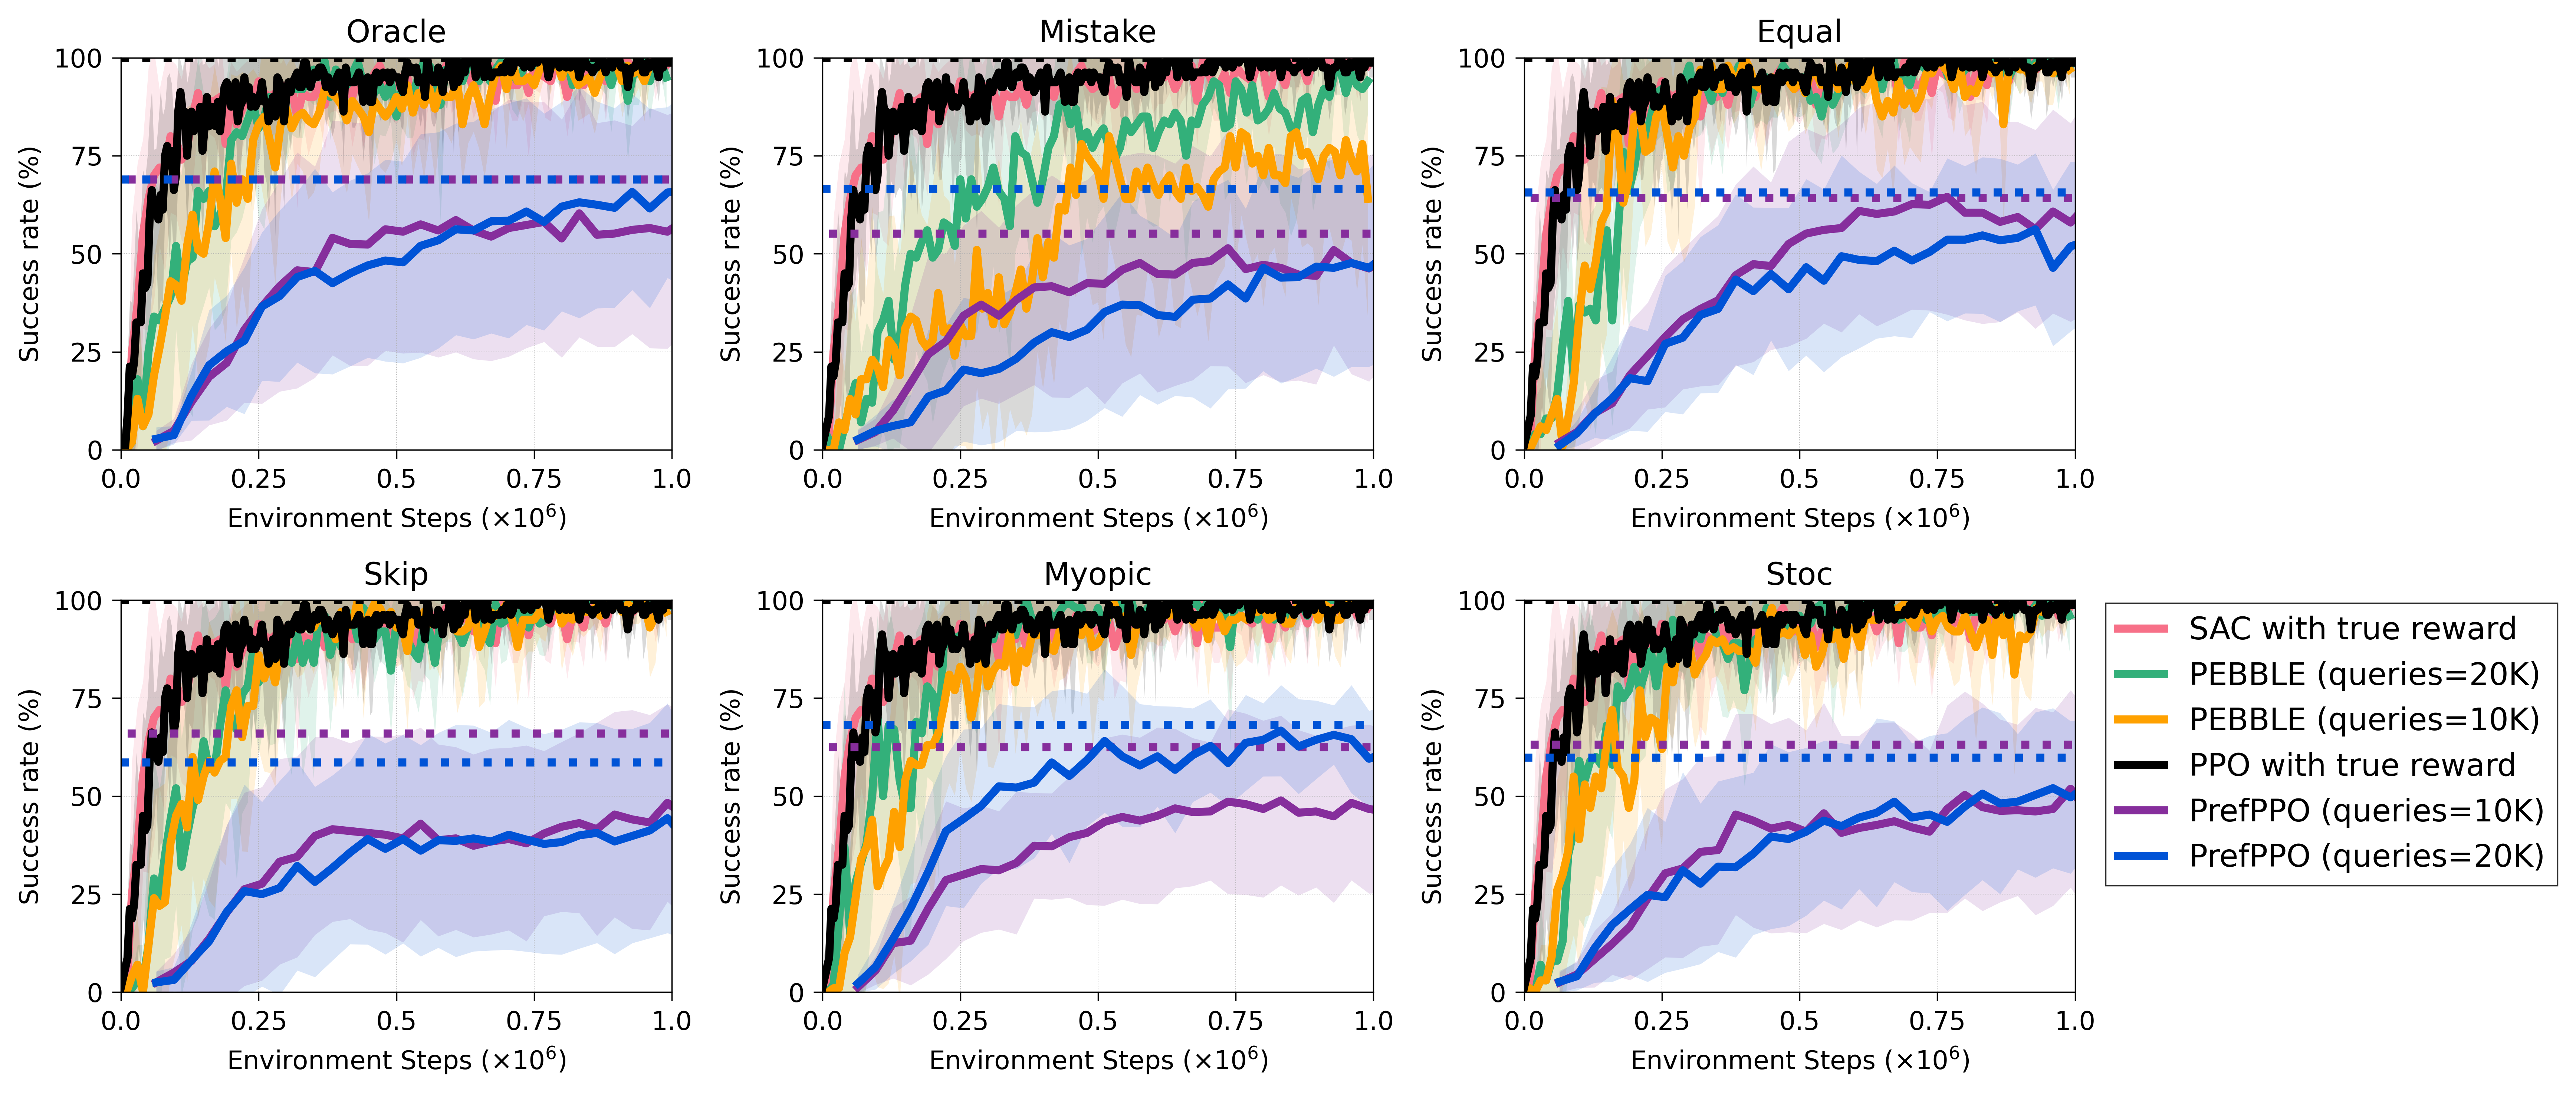

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
prefppo_2K_list, prefppo_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
    for name in sac_normal_name_list:
        label = name
        score = sac_normal_s_avg[name]
        std = sac_normal_s_std[name]
        steps = sac_normal_s_step[name].reshape(-1)
        ours_color = color_list[0]
        ax = draw_figures(steps/base, score, std, ax, 
                          sac_color, 'SAC with true reward') 
        sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_s_avg[name]
        std = new_pebble_s_std[name]
        steps = new_pebble_s_step[name].reshape(-1)
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=100' in name:
            ours_color = color_list[3]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=20K)')
            pebble_2K_max = np.max(score[max_window:])
            
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=50' in name:
            ours_color = color_list[5]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=10K)')
            pebble_1K_max = np.max(score[max_window:])
            
    for name in ppo_normal_name_list:            
        label = name
        score = s_ppo_normal_avg[name]
        std = s_ppo_normal_std[name]
        steps = s_ppo_normal_step[name].reshape(-1)
        ppo_color = color_list[6]
        ax = draw_figures(steps/base, score, std, ax, 
                          ppo_color, 'PPO with true reward')
        
        final_per = np.zeros(steps.shape[0])
        steps[0] = 0
        final_per[:] = np.max(score[max_window:])
        ppo_max = np.max(score[max_window:])
        ax = draw_figures(steps/base, final_per, 0, ax, 
                          ppo_color, '', dash=2)
    
            
    for name in un_pre_ppo_name_list:
        label = name
        score = s_un_pre_ppo_avg[name]
        std = s_un_pre_ppo_std[name]
        steps = s_un_pre_ppo_step[name].reshape(-1)

        if preppo_feed_type in name and teacher_flag in name:
            if 'max=20000' in name:
                ours_color = color_list[2]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=20K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 0
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_2K_max = np.max(score[max_window:])
            elif 'max=10000' in name:
                ours_color = new_purple_color
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=10K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 12000
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_1K_max = np.max(score[max_window:])
    
    pebble_2K_list.append(pebble_2K_max/sac_max)
    pebble_1K_list.append(pebble_1K_max/sac_max)
    prefppo_2K_list.append(preppo_2K_max/ppo_max)
    prefppo_1K_list.append(preppo_1K_max/ppo_max)
    unprefppo_2K_list.append(un_preppo_2K_max/ppo_max)
    unprefppo_1K_list.append(un_preppo_1K_max/ppo_max)
    
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Success rate (%)', fontsize=10)
    ax.set_title(teacher_name, fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 25, 50, 75, 100])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    
    if index_ == 5:
        leg = ax.legend(fancybox=False, fontsize=12, bbox_to_anchor=(1.05, 1),
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

print('PEBBLE (2K):')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_2K_list[index]))
print('avg: ' + str(np.average(pebble_2K_list)))

print('\nPEBBLE (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_1K_list[index]))
print('avg: ' + str(np.average(pebble_1K_list)))

print('\nPrePPO + Pre (2K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_2K_list[index]))
print('avg: ' + str(np.average(unprefppo_2K_list)))
    
print('\nPrePPO + Pre (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_1K_list[index]))
print('avg: ' + str(np.average(unprefppo_1K_list)))
plt.savefig('./figure/table1_'+env_name+'.pdf')

PEBBLE (2K):
Oracle: 0.99
Mistake: 0.97
Equal: 1.0
Skip: 1.0
Myopic: 1.0
Stoc: 1.0
avg: 0.9933333333333333

PEBBLE (1K): 
Oracle: 0.99
Mistake: 0.79
Equal: 0.99
Skip: 1.0
Myopic: 1.0
Stoc: 0.99
avg: 0.96

PrePPO + Pre (2K): 
Oracle: 0.8891129032258065
Mistake: 0.8588709677419355
Equal: 0.8467741935483871
Skip: 0.7560483870967742
Myopic: 0.8790322580645161
Stoc: 0.7721774193548387
avg: 0.8336693548387096

PrePPO + Pre (1K): 
Oracle: 0.8891129032258065
Mistake: 0.7116935483870968
Equal: 0.8286290322580645
Skip: 0.8508064516129032
Myopic: 0.8064516129032258
Stoc: 0.8145161290322581
avg: 0.8168682795698925


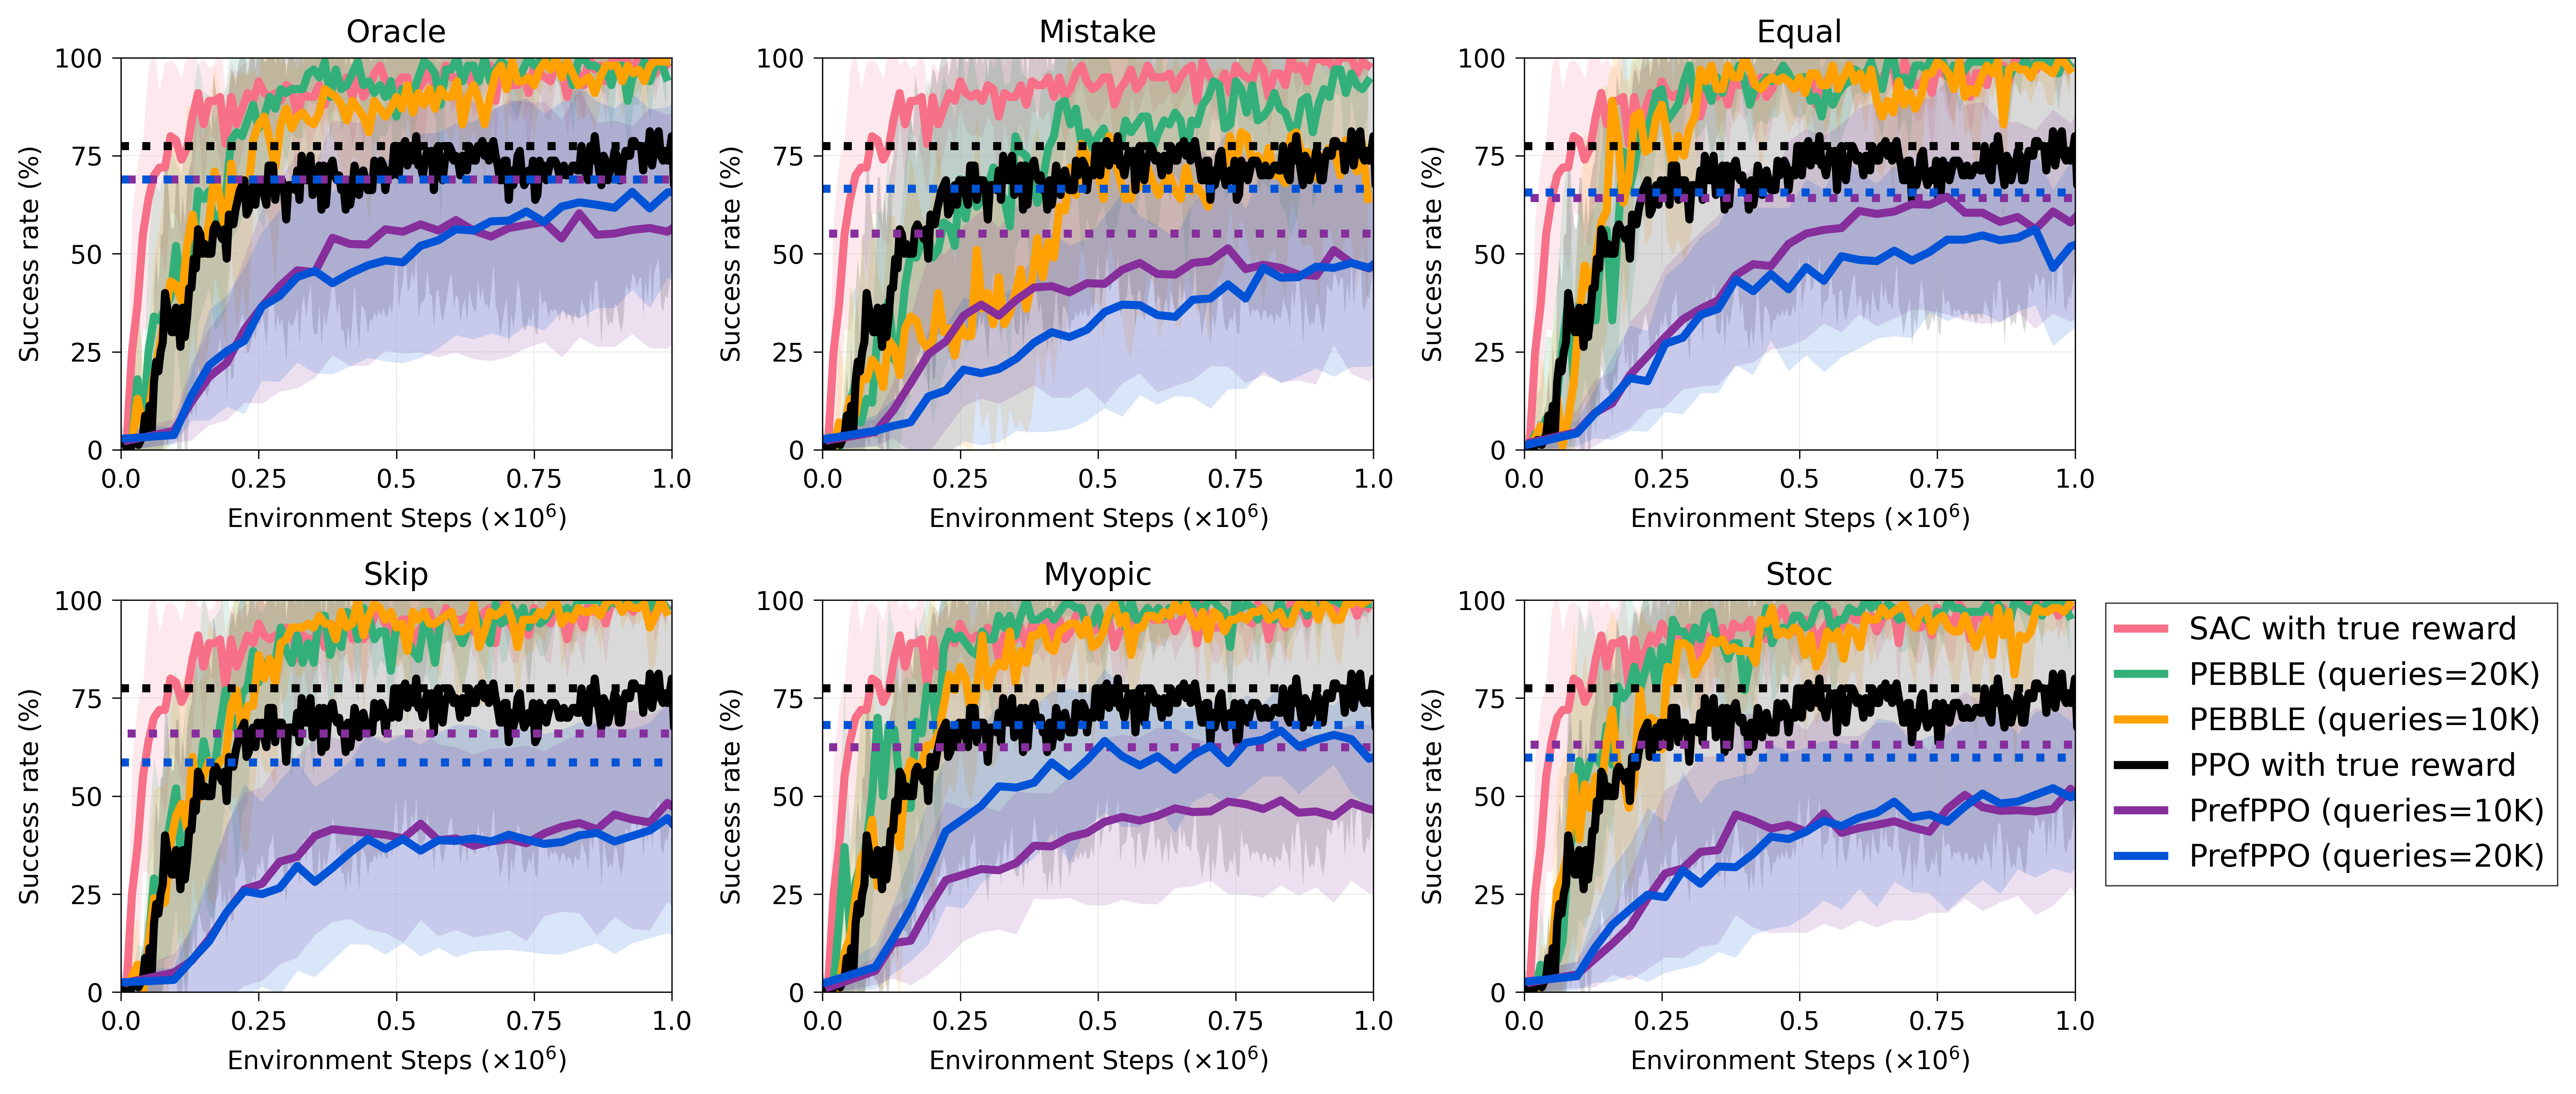

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000

teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']

sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]

pebble_feed_type = '[1]'
preppo_feed_type = '[1]'

pebble_2K_list, pebble_1K_list = [], []
prefppo_2K_list, prefppo_1K_list = [], []
unprefppo_2K_list, unprefppo_1K_list = [], []
max_window = -10
for index_, ax in enumerate(axes):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    sac_max, pebble_2K_max, pebble_1K_max = 0, 0, 0
    ppo_max, preppo_2K_max, preppo_1K_max = 0, 0, 0
    un_preppo_2K_max, un_preppo_1K_max = 0, 0
    
    for name in sac_normal_name_list:
        label = name
        score = sac_normal_s_avg[name]
        std = sac_normal_s_std[name]
        steps = sac_normal_s_step[name].reshape(-1)
        ours_color = color_list[0]
        ax = draw_figures(steps/base, score, std, ax, 
                          sac_color, 'SAC with true reward') 
        sac_max = np.max(score[max_window:])
    
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_s_avg[name]
        std = new_pebble_s_std[name]
        steps = new_pebble_s_step[name].reshape(-1)
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=100' in name:
            ours_color = color_list[3]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=20K)')
            pebble_2K_max = np.max(score[max_window:])
            
        if pebble_feed_type in name and teacher_flag in name and 'num_feed=50' in name:
            ours_color = color_list[5]
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, 'PEBBLE (queries=10K)')
            pebble_1K_max = np.max(score[max_window:])
            
    for name in ppo_un_normal_name_list:            
        label = name
        score = s_ppo_un_normal_avg[name]
        std = s_ppo_un_normal_std[name]
        steps = s_ppo_un_normal_step[name].reshape(-1)
        ppo_color = color_list[6]
        ax = draw_figures(steps/base, score, std, ax, 
                          ppo_color, 'PPO with true reward')
        
        final_per = np.zeros(steps.shape[0])
        steps[0] = 0
        final_per[:] = np.max(score[max_window:])
        ppo_max = np.max(score[max_window:])
        ax = draw_figures(steps/base, final_per, 0, ax, 
                          ppo_color, '', dash=2)
    
            
    for name in un_pre_ppo_name_list:
        label = name
        score = s_un_pre_ppo_avg[name]
        std = s_un_pre_ppo_std[name]
        steps = s_un_pre_ppo_step[name].reshape(-1)

        if preppo_feed_type in name and teacher_flag in name:
            if 'max=20000' in name:
                ours_color = color_list[2]
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=20K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 0
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_2K_max = np.max(score[max_window:])
            elif 'max=10000' in name:
                ours_color = new_purple_color
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'PrefPPO (queries=10K)')

                final_per = np.zeros(steps.shape[0])
                steps[0] = 12000
                final_per[:] = np.max(score[max_window:])
                ax = draw_figures(steps/base, final_per, 0, ax, 
                                  ours_color, '', dash=2)
                un_preppo_1K_max = np.max(score[max_window:])
    
    pebble_2K_list.append(pebble_2K_max/sac_max)
    pebble_1K_list.append(pebble_1K_max/sac_max)
    prefppo_2K_list.append(preppo_2K_max/ppo_max)
    prefppo_1K_list.append(preppo_1K_max/ppo_max)
    unprefppo_2K_list.append(un_preppo_2K_max/ppo_max)
    unprefppo_1K_list.append(un_preppo_1K_max/ppo_max)
    
    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Success rate (%)', fontsize=10)
    ax.set_title(teacher_name, fontsize=12)

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 25, 50, 75, 100])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    
    if index_ == 5:
        leg = ax.legend(fancybox=False, fontsize=12, bbox_to_anchor=(1.05, 1),
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)
plt.tight_layout()

print('PEBBLE (2K):')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_2K_list[index]))
print('avg: ' + str(np.average(pebble_2K_list)))

print('\nPEBBLE (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(pebble_1K_list[index]))
print('avg: ' + str(np.average(pebble_1K_list)))

print('\nPrePPO + Pre (2K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_2K_list[index]))
print('avg: ' + str(np.average(unprefppo_2K_list)))
    
print('\nPrePPO + Pre (1K): ')
for index in range(len(teacher_name_list)):
    teacher_name = teacher_name_list[index]
    print(teacher_name + ': ' + str(unprefppo_1K_list[index]))
print('avg: ' + str(np.average(unprefppo_1K_list)))

# Data generation - SAC

In [23]:
## Variables
max_window = -10
teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']
## Extract score
for name in sac_normal_name_list:
    label = name
    score = sac_normal_s_avg[name]
    sac_max = np.max(score)

for name in sac_un_normal_name_list:
    label = name
    score = sac_un_normal_s_avg[name]
    sac_un_max = np.max(score)
    
PEBBLE_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    for name in new_pebble_name_list:
        label = name
        if teacher_flag in name:
            if 'num_feed=100' in name:
                store_name = "PEBBLE (20K) (" + teacher_name + ")"
            if 'num_feed=50' in name:
                store_name = "PEBBLE (10K) (" + teacher_name + ")"
            total_score = new_pebble_s_total[name]
            print(total_score.shape)
            print(store_name)
            sac_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_max
            sac_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_un_max
            print(sac_norm.shape)
            PEBBLE_score[store_name] = sac_norm.reshape(-1,1)
#             PEBBLE_score[store_name + " UnSup"] = sac_un_norm.reshape(-1,1)

(10, 99)
PEBBLE (20K) (Oracle)
(10,)
(10, 99)
PEBBLE (10K) (Oracle)
(10,)
(10, 99)
PEBBLE (20K) (Mistake)
(10,)
(10, 99)
PEBBLE (10K) (Mistake)
(10,)
(10, 99)
PEBBLE (20K) (Equal)
(10,)
(10, 99)
PEBBLE (10K) (Equal)
(10,)
(10, 99)
PEBBLE (20K) (Skip)
(10,)
(10, 99)
PEBBLE (10K) (Skip)
(10,)
(10, 99)
PEBBLE (20K) (Myopic)
(10,)
(10, 99)
PEBBLE (10K) (Myopic)
(10,)
(10, 99)
PEBBLE (20K) (Stoc)
(10,)
(10, 99)
PEBBLE (10K) (Stoc)
(10,)


In [19]:
for name in ppo_normal_name_list:            
    label = name
    score = s_ppo_normal_avg[name]
    ppo_max = np.max(score)
    
for name in ppo_un_normal_name_list:            
    label = name
    score = s_ppo_un_normal_avg[name]
    ppo_un_max = np.max(score)

PrefPPO_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    for name in un_pre_ppo_name_list:
        label = name
        if teacher_flag in name:
            if 'max=20000' in name:
                store_name = "PrefPPO (20K) (" + teacher_name + ")"
            elif 'max=10000' in name:
                store_name = "PrefPPO (10K) (" + teacher_name + ")"
            
            total_score = s_un_pre_ppo_tot[name]
            ppo_norm = np.mean(total_score[:,max_window:-1], axis=1) / ppo_max
            ppo_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / ppo_un_max
            PrefPPO_score[store_name] = ppo_norm.reshape(-1,1)
#             PrefPPO_score[store_name + " UnSup"] = ppo_un_norm.reshape(-1,1)

In [20]:
save_dict(PEBBLE_score, './data/button_pebble.pkl')
save_dict(PrefPPO_score, './data/button_prefppo.pkl')